# Imports

In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from tqdm import tqdm
import statsmodels.formula.api as smf
import pandas as pd
tqdm.pandas()

/Users/o.weisse/switchback_test_dag/venv/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


# Sample sizes (no. orders) per country in two weeks

In [2]:
client = bigquery.Client(project = 'logistics-data-staging-flat')

In [3]:
query = """
SELECT
entity_id,
count(*) number_of_orders
FROM `fulfillment-dwh-production.cl.orders_v2`orders
WHERE created_date BETWEEN "2023-05-01" AND "2023-05-14"
GROUP BY entity_id
ORDER BY number_of_orders
"""

In [4]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/79 [00:00<?, ?rows/s]

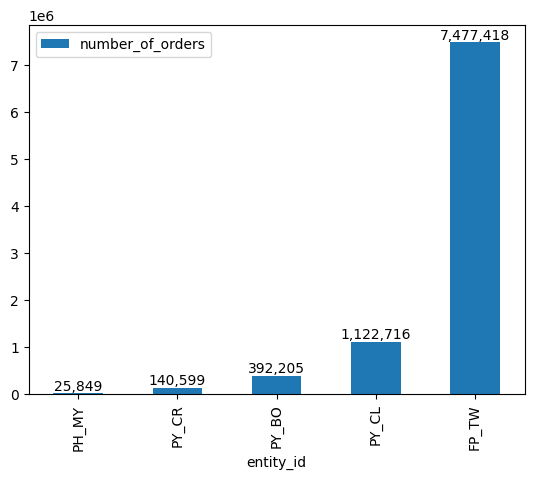

In [5]:
ax = data[data['entity_id'].isin(['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"])].set_index('entity_id').plot.bar()

# Add numbers above the bars
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',')), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Download Data

In [6]:
def download_data(entity_ids, start_date, end_date):
    query = f"""
    SELECT
    entity_id,
    rider.city_id,
    created_date,
    created_at,
    orders.rider.timings.actual_delivery_time/60 delivery_time,
    orders.rider.timings.order_delay/60 order_delay,
    orders.rider.timings.bag_time/60 bag_time,
    --ARRAY(SELECT d.dropoff_distance_manhattan FROM UNNEST(orders.rider.deliveries) AS d)[OFFSET(0)] distance,
    FROM `fulfillment-dwh-production.cl.orders_v2`orders
    WHERE created_date BETWEEN "{start_date}" AND "{end_date}"
    AND entity_id in {tuple(entity_ids)}
    """

    bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
    data = client.query(query).result()\
    .to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')
    return data

In [7]:
entity_ids = ['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"]
start_date = "2023-05-01"
end_date = "2023-05-14"
data = download_data(entity_ids, start_date, end_date)

Downloading:   0%|          | 0/9158787 [00:00<?, ?rows/s]

In [16]:
KPI = "delivery_time"

In [17]:
# filter
data = data[data['delivery_time']<120]
data = data[data['delivery_time']>0]
data = data[data[KPI].notnull()]

<AxesSubplot:xlabel='delivery_time', ylabel='Density'>

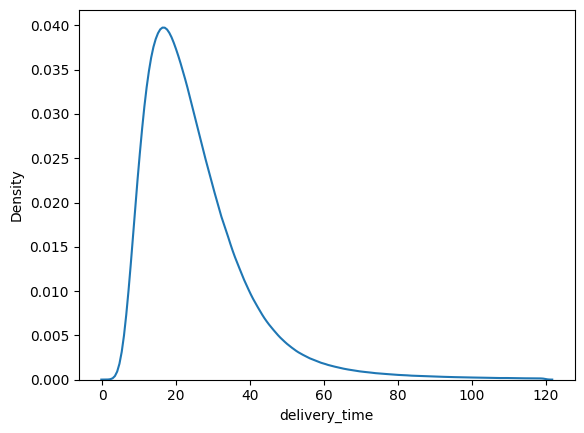

In [288]:
sns.kdeplot(data[KPI])

In [77]:
data[KPI].mean()

26.02884197674707

# Confidence Intervals per window size

In [10]:
def randomize_time_unit_assignment(data):
    """Creates a new columns called 'group'. Assigns each time unit randomly to either group A or B."""
    time_unit_group_dict = {i: np.random.choice(['A', 'B']) for i in data.time_unit.unique()}
    data['group'] = data['time_unit'].map(time_unit_group_dict)

In [11]:
def CRSE_CI(data, KPI):
    """Calculates the CI for cluster robust standard error method."""
    data["group_binary"] = data['group'].map({"A":0, "B": 1})
    model = smf.ols(formula=f'{KPI} ~ group_binary', data=data)
    results = model.fit(cov_type="cluster", cov_kwds={'groups': data['time_unit']})
    std_err = results.bse["group_binary"]
    mean_diff = results.params["group_binary"]
    return std_err, mean_diff

In [12]:
def get_CIs_for_different_window_sizes(CI_function, KPI, window_sizes):
    """Calculates confidence intervals for a certain method for different specified window_sizes."""
    CIs = []
    for window_size in tqdm(window_sizes):
        data['time_unit'] = data['created_at'].dt.floor(window_size)
        randomize_time_unit_assignment(data)
        CI, _ = CI_function(data, KPI)
        CIs.append(CI)
    return pd.Series(CIs, index=window_sizes, name=CI_function.__name__)

In [233]:
# assign to group with hourly switchback interval
data['time_unit'] = data['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data)

In [236]:
# calculate CIs
results = data.groupby('entity_id').progress_apply(lambda data: 2*CRSE_CI(data, KPI)[0])
results.name = "CI"

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.64s/it]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

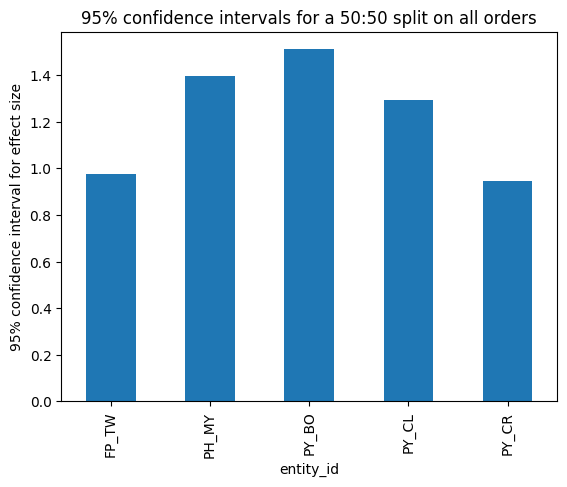

In [237]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

In [239]:
mean_KPI = data.groupby('entity_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

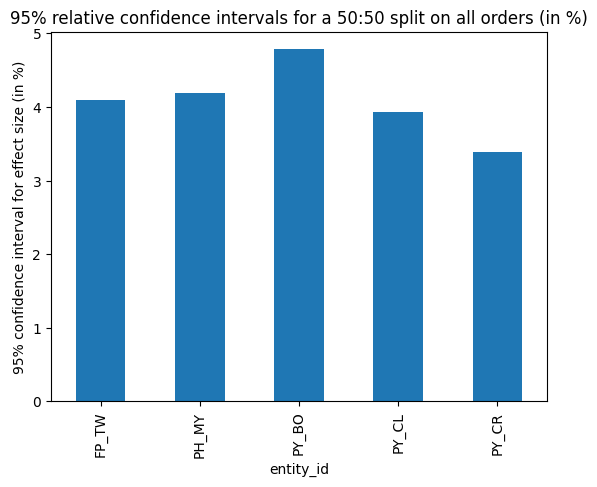

In [240]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

In [249]:
grouped_data = data.groupby(['time_unit', 'entity_id'])[KPI].mean().unstack()

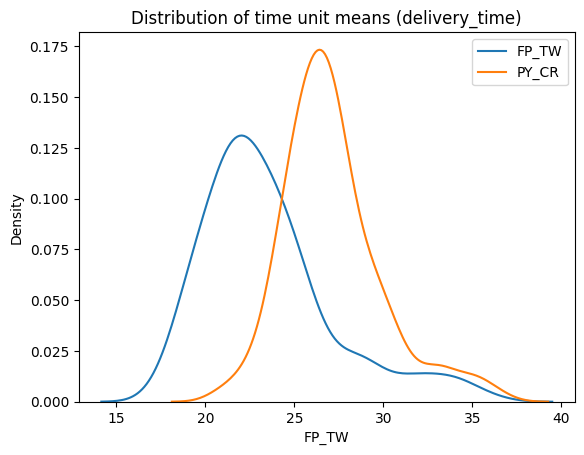

In [269]:
sns.kdeplot(grouped_data['FP_TW'])
sns.kdeplot(grouped_data['PY_CR'])
plt.title(f'Distribution of time unit means ({KPI})')
plt.legend(['FP_TW', "PY_CR"])

Text(0.5, 1.0, 'time units means over time')

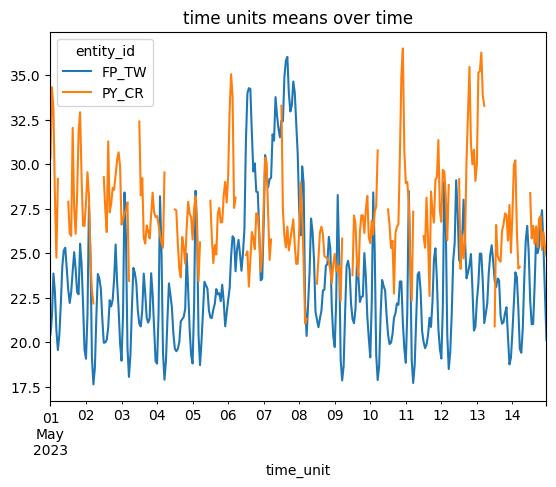

In [270]:
grouped_data[["FP_TW", "PY_CR"]].plot()
plt.title('time unit means over time')

# Increase length of test

In [274]:
entity_ids = ['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"]
start_date = "2023-05-01"
end_date = "2023-06-01"
data = download_data(entity_ids, start_date, end_date)

Downloading:   0%|          | 0/20681768 [00:00<?, ?rows/s]

In [275]:
# filter
data = data[data['delivery_time']<120]
data = data[data['delivery_time']>0]
data = data[data[KPI].notnull()]

In [276]:
# assign to group with hourly switchback interval
data['time_unit'] = data['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data)

In [277]:
# calculate CIs
results = data.groupby('entity_id').progress_apply(lambda data: 2*CRSE_CI(data, KPI)[0])
results.name = "CI"

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.23s/it]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

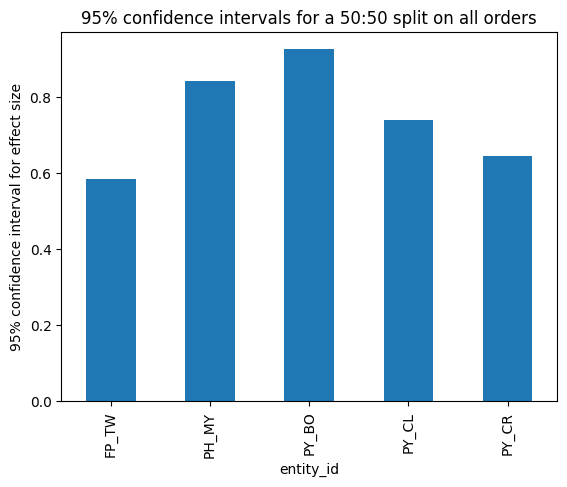

In [278]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

In [279]:
mean_KPI = data.groupby('entity_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

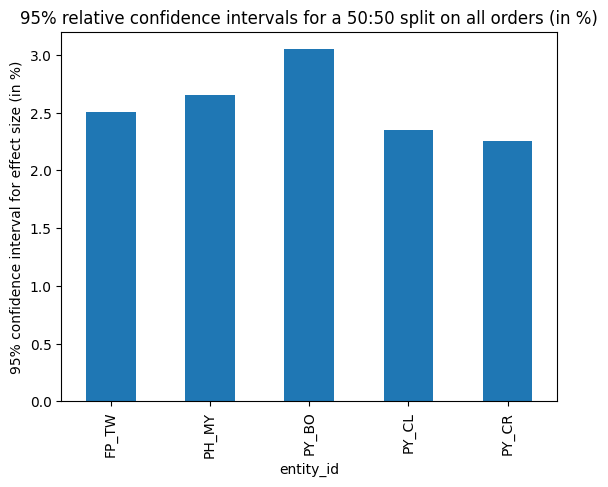

In [280]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

# Find correlated cities

In [18]:
# assign to group with hourly switchback interval
data['time_unit'] = data['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data)

In [19]:
data['entity_city_id'] = data['entity_id']+data['city_id'].astype(str)

In [20]:
time_unit_means = data.groupby(['time_unit', 'entity_city_id'])[KPI].mean().unstack()

In [21]:
time_unit_means.corr()['FP_TW1'].sort_values().iloc[-2:-1]

entity_city_id
FP_TW202    0.753595
Name: FP_TW1, dtype: float64

Text(0.5, 1.0, 'DT means per time unit')

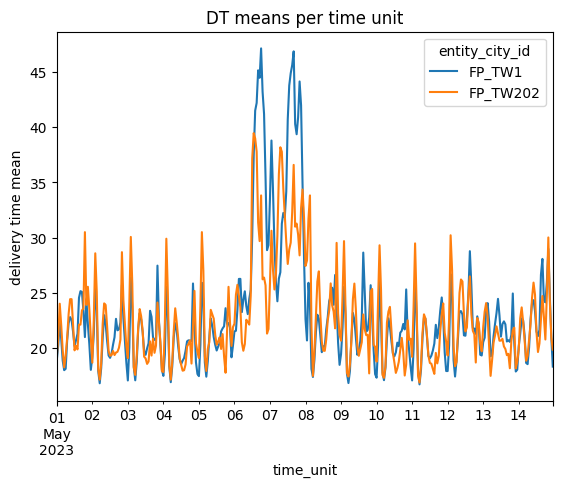

In [22]:
time_unit_means[['FP_TW1', "FP_TW202"]].plot()
plt.ylabel('delivery time mean')
plt.title("DT means per time unit")

### FPR analysis for counterpart method

In [ ]:
def randomize_time_unit_assignment_counterpart(data, counterpart_column, counterpart1, counterpart2):
    """Creates a new column called 'group'. Assigns each time unit randomly to either group A or B. It does so
    for two counterparts that are similar like the city_id. If one city is assigned to A, the other city is assigned
    to be B at the same time."""
    time_unit_group_dict = {i: np.random.choice(['A', 'B']) for i in data.time_unit.unique()}
    time_unit_group_dict_reversed = {i:"A" if (time_unit_group_dict[i] == "B") else "B" for i in time_unit_group_dict}
    data['original_group'] = data['time_unit'].map(time_unit_group_dict)
    data['reversed_group'] = data['time_unit'].map(time_unit_group_dict_reversed)
    data['group'] = np.where(data[counterpart_column]!=counterpart1, data['original_group'], data['reversed_group'])

In [ ]:
def CRSE_significance(data, KPI_A, KPI_B, threshold=0):
    """Uses the cluster robust standard error method to check for significance."""
    data["group_binary"] = data['group'].map({"A":0, "B": 1})
    data['KPI'] = np.where(data['group']=="A", data[KPI_A], data[KPI_B])
    model = smf.ols(formula=f'KPI ~ group_binary', data=data)
    p = model.fit(cov_type="cluster", cov_kwds={'groups': data['time_unit']}).pvalues["group_binary"]
    if p < 0.05:
        return True

In [ ]:
def FPR(data, KPI, randomization_function, counterpart_column, counterpart1, counterpart2, n_iterations=1000, 
        threshold = 0):
    """Calculates the false positive rate for the CRSE for different randomization methods."""
    effect_found = 0
    for i in tqdm(range(n_iterations)):
        if randomization_function == randomize_time_unit_assignment:
            randomization_function(data)
        else:
            randomization_function(data, counterpart_column, counterpart1, counterpart2)
        if CRSE_significance(data, KPI, KPI, threshold):
            effect_found += 1
    return effect_found/n_iterations

In [552]:
data_two_cities = data[data['entity_city_id'].isin(["FP_TW1", "FP_TW202"])].sample(frac=0.01)
FPR(data_two_cities, "delivery_time", randomize_time_unit_assignment, "entity_city_id", "FP_TW1", "FP_TW202", 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:19<00:00,  7.16it/s]


0.051

In [554]:
FPR(data_two_cities, "delivery_time", randomize_time_unit_assignment_counterpart, 
    "entity_city_id", "FP_TW1", "FP_TW202", 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:35<00:00,  6.42it/s]


0.059

### power analysis for counterpart method

In [557]:
def power(data, KPI, effect_size, randomization_function, counterpart_column, counterpart1, counterpart2, n_iterations=1000, 
        threshold = 0):
    """Calculates the false positive rate for the CRSE for different randomization methods."""
    effect_found = 0
    for i in tqdm(range(n_iterations)):
        if randomization_function == randomize_time_unit_assignment:
            randomization_function(data)
        else:
            randomization_function(data, counterpart_column, counterpart1, counterpart2)
        data[KPI+"_simulated"] = data[KPI]+effect_size
        if CRSE_significance(data, KPI, KPI+"_simulated", threshold):
            effect_found += 1
    return effect_found/n_iterations

In [558]:
power(data_two_cities, "delivery_time", 1, randomize_time_unit_assignment, "entity_city_id", "FP_TW1", "FP_TW202", 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.71it/s]


0.371

In [560]:
power(data_two_cities, "delivery_time", 1, randomize_time_unit_assignment_counterpart, "entity_city_id", "FP_TW1", "FP_TW202", 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.76it/s]


0.692

### Confidence Intervals for counterpart method

In [ ]:
def get_difference_distribution(data, randomization_function, counterpart_column, counterpart1, counterpart2,
                                n_iterations=100):
    """Get the difference distribution between the means of A and B by bootstrapping."""
    measured_effects = []
    for i in tqdm(range(100)):
        if randomization_function == randomize_time_unit_assignment:
            randomization_function(data)
        else:
            randomization_function(data, counterpart_column, counterpart1, counterpart2)
        measured_effect = data[data['group']=='A'][KPI].mean()-data[data['group']=='B'][KPI].mean()
        measured_effects.append(measured_effect)
    return measured_effects

In [465]:
diff_distribution = get_difference_distribution(
    data_two_cities,randomize_time_unit_assignment, "entity_city_id", "FP_TW1", "FP_TW202", 100)

diff_distribution_counterpart = get_difference_distribution(
    data_two_cities,randomize_time_unit_assignment_counterpart, "entity_city_id", "FP_TW1", "FP_TW202", 100)

  0%|                                                                                                                                               | 0/100 [00:00<?, ?it/s]/var/folders/9g/r04zryz50gqdsscmvr2kvj3ddh1wcn/T/ipykernel_72302/2566844258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = data['time_unit'].map(time_unit_group_dict)
  0%|                                                                                                                                               | 0/100 [00:00<?, ?it/s]/var/folders/9g/r04zryz50gqdsscmvr2kvj3ddh1wcn/T/ipykernel_72302/1252266070.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

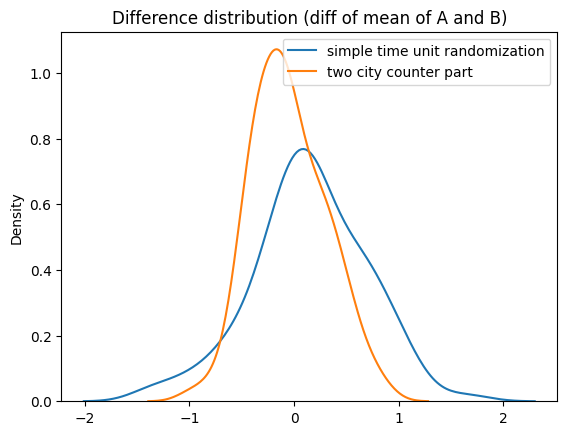

In [466]:
sns.kdeplot(diff_distribution)
sns.kdeplot(diff_distribution_counterpart)
plt.title('Difference distribution (diff of mean of A and B)')
plt.legend(["simple time unit randomization", "two city counter part"])

In [467]:
np.std(diff_distribution)

0.543234290876088

In [468]:
np.std(diff_distribution_counterpart)

0.3522177627574973

In [563]:
randomize_time_unit_assignment(data_two_cities)
CRSE_CI(data_two_cities, KPI)

(0.6004886838375213, -0.8374986085262084)

In [564]:
randomize_time_unit_assignment_counterpart(data_two_cities, "entity_city_id", "FP_TW1", "FP_TW202")
CRSE_CI(data_two_cities, KPI)

(0.39787336823782876, -0.4888450414127095)

<AxesSubplot:xlabel='time_unit'>

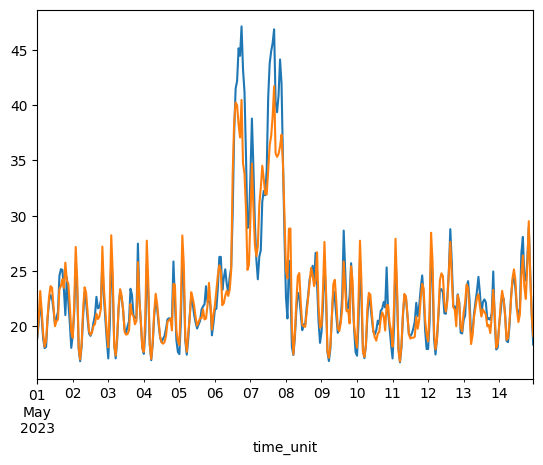

In [23]:
(time_unit_means['FP_TW1']).plot()
(0.5*time_unit_means['FP_TW1']+0.5*time_unit_means['FP_TW202']).plot()

In [24]:
time_unit_means['FP_TW1'].std()

5.7692842594467075

In [25]:
time_unit_means['diff'] = time_unit_means['FP_TW1']-time_unit_means['FP_TW202']
time_unit_means['diff'].std()

3.792385528513498

In [26]:
time_unit_means['diff'] = time_unit_means['FP_TW1']
time_unit_means['diff'] -= 0.25*time_unit_means['FP_TW202']
time_unit_means['diff'] -= 0.25*time_unit_means['FP_TW2']
time_unit_means['diff'] -= 0.25*time_unit_means['FP_TW209']
time_unit_means['diff'] -= 0.25*time_unit_means['FP_TW205']
time_unit_means['diff'].std()

3.4756583497683433

<AxesSubplot:xlabel='time_unit'>

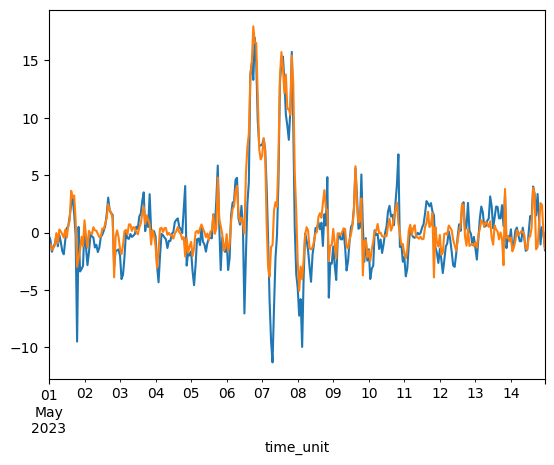

In [27]:
(time_unit_means['FP_TW1']-time_unit_means['FP_TW202']).plot()
time_unit_means['diff'].plot()

In [28]:
time_unit_means.corr()['FP_TW1'].sort_values().head(30)

entity_city_id
PY_CL211   -0.299029
PY_CL200   -0.160098
PY_CL220   -0.144243
PY_CL221   -0.135262
PY_CL225   -0.135206
PY_CL232   -0.120898
PY_CR16    -0.102559
PY_CR1     -0.102440
PY_CL228   -0.069663
PY_CL1     -0.067030
PY_CR7     -0.062745
PY_CL209   -0.061344
PY_CL204   -0.056588
PY_CL217   -0.046727
PY_CL233   -0.044587
PY_CL201   -0.042688
PY_CL207   -0.041137
PY_CL218   -0.038530
PY_CL205   -0.032949
PH_MY209   -0.032843
PY_CL229   -0.028154
PY_CR10    -0.027773
PY_CR8     -0.020740
PY_CL216   -0.019097
PY_CL222   -0.012063
PH_MY216   -0.010668
PY_CR18    -0.008589
PY_BO6     -0.007047
PY_CL203   -0.005865
PH_MY213   -0.001554
Name: FP_TW1, dtype: float64

In [29]:
t = "FP_TW208"
(time_unit_means['FP_TW1']-time_unit_means[t]).std()

5.31197815281748

In [30]:
(0.5*time_unit_means['FP_TW1']+0.5*time_unit_means[t]).std()

3.570707455336547